# DDPG Agent 

## Import necessary modules

In [85]:
# --- General NN and math libraries --- #
import numpy as np
import torch

# --- For Measuring performance --- #
from collections import deque
from statistics import mean, stdev
import matplotlib.pyplot as plt

# --- For Loading the environment --- #
from e_env import environment_loader

# --- For plotting and saving --- #
from constants import *             # Capital lettered variables are constants from the constants.py file
import time
import csv
from monitor import render_save_graph, save_scores, read_scores
print_constants()

# --- Loading and Nameing utilities --- #
from helper import load_previous, get_constant_string


--- General Training parameters ---
DEVICE:  cuda:0
SCORES_WINDOW:  100
SAVE_PATH:  Trained_Agents/
SAVE_EXP_PATH:  Experiments/

--- Replay Buffer parameters ---
BUFFER_SIZE:  100000
UPDATE_EVERY:  4
BATCH_SIZE:  100

--- Learning parameters ---
GAMMA:  0.99
LR_ACTOR:  0.0001
LR_CRITIC:  0.0001
CRITERION:  <function mse_loss at 0x000002938B4A4EA0>
WEIGHT_DECAY:  0
TAU:  0.001

--- OUNoise ---
MU:  0.0
THETA:  0.15
SIGMA:  0.1


In [2]:
# --- For Loading the agent --- #
# We don't need to reimport the agent everytime we change one of it's values
%load_ext autoreload
%autoreload 2
from a_agent import DDPG_Agent


--- General Training parameters ---
DEVICE:  cuda:0

--- Replay Buffer parameters ---
BUFFER_SIZE:  100000
UPDATE_EVERY:  4
BATCH_SIZE:  100

--- Learning parameters ---
GAMMA:  0.99
LR_ACTOR:  0.0001
LR_CRITIC:  0.0001
CRITERION:  <function mse_loss at 0x000002938B4A4EA0>
WEIGHT_DECAY:  0
TAU:  0.001

--- OUNoise ---
MU:  0.0
THETA:  0.15
SIGMA:  0.1


## Load Environment
Environment is loaded with a helper function in ENV.py
The helper function returns the envrionment object, the state size and action size, the brain's name and how many agents there are in the environment

In [3]:
env, state_size, action_size, brain_name, num_agents = environment_loader("Reacher_Single/Reacher.exe", no_graphics = True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00

# Train Agent

In [4]:
def DDPG_train(agent, env, max_t=100, num_episodes = 1, scores_window=SCORES_WINDOW, existing_score=[]):
    score_history = existing_score
    print("Continuing training -> initial Score History length: ", len(score_history))
    
    scores_deque = deque(score_history[-scores_window:], maxlen=scores_window)
    last_running_mean = float('-inf')

    for episode in range(num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        agent.reset()                                          # reset the noise in the agent
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        score = 0

        for i in range(max_t):
            actions = agent.act(states[0])                     # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states[0], actions, rewards[0], next_states[0], dones[0])

            score += env_info.rewards[0]

            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        

        #returns_in_episode = np.mean(scores)
        returns_in_episode = score
        scores_deque.append(returns_in_episode)
        score_history.append(returns_in_episode)
        if episode > scores_window:
            if mean(scores_deque) > last_running_mean:
                    print("")
                    print('Last {} was better, going to save it'.format(scores_window))
                    _, filename = get_constant_string()
                    torch.save(new_agent.actor_local.state_dict(), '{}/{}_actor.pth'.format(SAVE_PATH, filename))
                    torch.save(new_agent.critic_local.state_dict(), '{}/{}_critic.pth'.format(SAVE_PATH, filename))
                    last_running_mean = mean(scores_deque)

        print("\r", 'Total score (averaged over agents) {} episode: {} | \tAvarage in last {} is {}'.format(episode, returns_in_episode, scores_window, np.mean(scores_deque)), end="")

    

    return score_history

In [6]:
new_agent = DDPG_Agent(state_size, action_size, random_seed = 1, actor_hidden = ACTOR_H, critic_hidden=CRITIC_H)


--- Agent Params ---
Going to train on cuda:0
Learning Rate:: Actor: 0.0001 | Critic: 0.0001
Replay Buffer:: Buffer Size: 100000 | Sampled Batch size: 100

Actor paramaters:: Input: 33 | Hidden Layers: [128, 128] | Output: 4
Critic paramaters:: Input: 33 | Hidden Layers: [132, 128] | Output: 1
Actor(
  (fc_in): Linear(in_features=33, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
)
Critic(
  (fc_in): Linear(in_features=33, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=132, out_features=128, bias=True)
  )
  (fc_out): Linear(in_features=128, out_features=1, bias=True)
)




In [7]:
score_history = DDPG_train(new_agent, env, max_t = 1001, num_episodes = 500, scores_window=SCORES_WINDOW)

04481
Last 100 was better, going to save it
 Total score (averaged over agents) 252 episode: 14.419999677687883 | 	Avarage in last 100 is 10.683399761207403
Last 100 was better, going to save it
 Total score (averaged over agents) 253 episode: 16.949999621137977 | 	Avarage in last 100 is 10.736299760024995
Last 100 was better, going to save it
 Total score (averaged over agents) 254 episode: 18.96999957598746 | 	Avarage in last 100 is 10.86719975709915
Last 100 was better, going to save it
 Total score (averaged over agents) 255 episode: 21.829999512061477 | 	Avarage in last 100 is 11.010099753905088
Last 100 was better, going to save it
 Total score (averaged over agents) 258 episode: 17.42999961040914 | 	Avarage in last 100 is 11.00059975411743
Last 100 was better, going to save it
 Total score (averaged over agents) 259 episode: 20.089999550953507 | 	Avarage in last 100 is 11.153099750708789
Last 100 was better, going to save it
 Total score (averaged over agents) 261 episode: 9.569

# Display and Save results

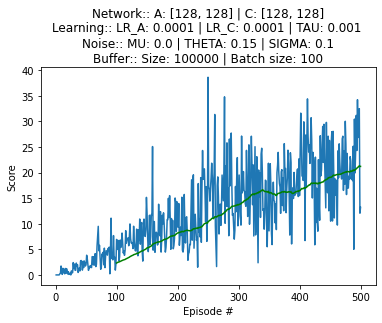

In [82]:
render_save_graph(score_history, scores_window = SCORES_WINDOW)

In [83]:
save_scores(score_history, path=SAVE_EXP_PATH)

Scores saved!


# Continue last saved run
The next to cells 
- Import the scores of the last run
- If we saved weights of the Neural Net load those
- Continue training from last place

In [74]:
new_agent = load_previous(new_agent)

Found previous trained Agent, going to load them!


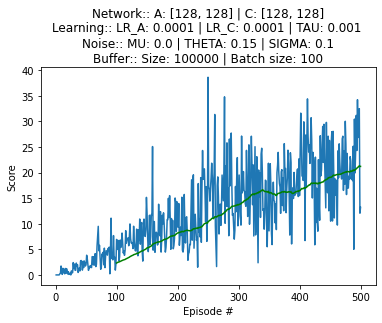

In [92]:
time_string='2021-04-17_1558'
read_score_history = read_scores(created_time=time_string, path=SAVE_EXP_PATH)

render_graph(read_score_history, scores_window = SCORES_WINDOW) # Check how it looks

In [ ]:
new_score_history = DDPG_train(new_agent, env, max_t = 1001, num_episodes = 150, existing_score=read_score_history, scores_window=SCORES_WINDOW)

In [ ]:
render_graph(new_score_history, scores_window = SCORES_WINDOW)

In [ ]:
save_scores(new_score_history, path=SAVE_EXP_PATH)

# See how the agent performs

In [ ]:
new_agent = DDPG_Agent(state_size, action_size, 5)
new_agent = load_previous(new_agent)

In [58]:
def DDPG_eval(agent, env, max_t=100):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    episode_length = 0                                     # measure number of steps allowed before done flag
    for i in range(max_t):
        # actions = np.random.randn(num_agents, action_size) # select an action (for each agent); randomly!
        actions =  np.random.randn(num_agents, action_size) if agent is None else agent.act(states[0]) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        episode_length +=1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode length is {}'.format(episode_length))
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

In [59]:
DDPG_eval(new_agent, env, max_t = 100000000000)

Episode length is 1001
Total score (averaged over agents) this episode: 18.69999958202243


In [ ]:
env.close()